# Structure from motion

Import everything *except* our sfm library.

In [1]:
# Import symforce for the sole purpose of setting the value
# of epsilon, which must be done first and exactly once.
import symforce
symforce.set_epsilon_to_symbol()

import importlib
from pathlib import Path
import numpy as np
import secrets
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import rerun as rr
from uuid import uuid4

Import our sfm library. (Re-evaluate this cell if you make changes to the library.)

In [19]:
import sfm
importlib.reload(sfm)

<module 'sfm' from '/Users/sam/Documents/phd/AE598/ae598-3dv/homework/03_sfm/sfm.py'>

Choose parameter values.

In [20]:
# When reading video frames
frames_to_skip = 30

# When matching (max threshold for ratio test)
matching_threshold = 0.5

# When deciding if triangulated points are invalid
max_reprojection_err = 0.75

# Camera matrix
K = np.array([
    [1565.7702703272157, 0.0, 964.2389356041999],
    [0.0, 1562.3561924508267, 537.4247202074102],
    [0.0, 0.0, 1.0],
])

Create random number generator.

In [21]:
seed = secrets.randbits(32)
print(f'seeding RNG with {seed}')
rng = np.random.default_rng(seed)

seeding RNG with 499417918


Initialize 3D visualizer (should open the rerun application if that isn't already open).

In [22]:
# Create recording with unique ID
rr.init('my_sfm', recording_id=uuid4(), spawn=True)

# Initialize a time sequence
rr.set_time_seconds('stable_time', 0)

# Make view coordinates consistent with camera frames (z forward, x right, y down)
rr.log('/results', rr.ViewCoordinates.RDF, timeless=True)

Found existing process on port 9876. Trying to connect.


Load images from video.

In [23]:
# Specify filename
video_filename = Path('../../tutorials/20240305_realdata_whatbreaks/video.MOV')

# Create a video reader
video_src = cv2.VideoCapture(str(video_filename))

# Get frame count and frames per second
frame_count = int(video_src.get(cv2.CAP_PROP_FRAME_COUNT))
frames_per_second = video_src.get(cv2.CAP_PROP_FPS)

# Read frames
views = []
for i_frame in range(0, frame_count, frames_to_skip):
    video_src.set(cv2.CAP_PROP_POS_FRAMES, i_frame)
    success, frame = video_src.read()
    assert(success)
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    views.append({
        'frame_id': i_frame,
        'img': img,
        'R_inB_ofA': None,
        'p_inB_ofA': None,
    })
print(f'read {len(views)} images from video')

read 11 images from video


Detection.

In [24]:
# Create a SIFT feature detector
sift = cv2.SIFT_create()

# Apply detector to find keypoints (pts) and descriptors (desc) in each image
for view in views:
    pts, desc = sift.detectAndCompute(image=view['img'], mask=None)
    view['pts'] = [
        {
            'pt2d': np.array(pt.pt),
            'track': None,
        }
        for pt in pts
    ]
    view['desc'] = desc

## Initialize with two-view reconstruction

### Get initial guess

Apply matcher.

In [25]:
matches = sfm.get_good_matches(views[0]['desc'], views[1]['desc'], threshold=matching_threshold)
print(f'found {len(matches)} good matches')

found 969 good matches


Store results.

In [26]:
tracks = []
for match in matches:
    track = {
        'p_inA': None,
        'valid': True,
        'matches': [
            {'view_id': 0, 'feature_id': match.queryIdx},
            {'view_id': 1, 'feature_id': match.trainIdx},
        ]
    }
    tracks.append(track)
    views[0]['pts'][match.queryIdx]['track'] = track
    views[1]['pts'][match.trainIdx]['track'] = track

Get image coordinates of matches.

In [27]:
# Create a, b
a = []
b = []
for m in matches:
    a.append(views[0]['pts'][m.queryIdx]['pt2d'])
    b.append(views[1]['pts'][m.trainIdx]['pt2d'])
a = np.array(a)
b = np.array(b)

Visualize all good matches.

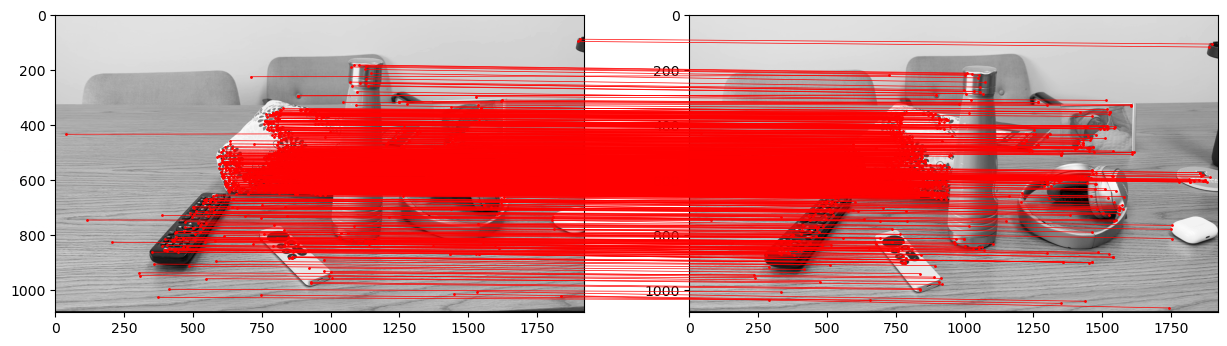

In [28]:
# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Show images
ax1.imshow(views[0]['img'], cmap='gray')
ax2.imshow(views[1]['img'], cmap='gray')

# Show matches
for a_i, b_i in zip(a, b):
    fig.add_artist(
        ConnectionPatch(
            a_i, b_i, 
            'data', 'data',
            axesA=ax1, axesB=ax2,\
            color='red',
            connectionstyle='arc3, rad=0.',
            linewidth=0.5,
        )
    )
    # - Draw red dot at each keypoint
    ax1.plot(a_i[0], a_i[1], 'r.', markersize=2)
    ax2.plot(b_i[0], b_i[1], 'r.', markersize=2)

plt.show()

Do reconstruction.

In [38]:
# Estimate essential matrix
E, num_inliers, mask = sfm.getE(a, b, K, rng, threshold=2e-3, num_iters=1000)
print(f'found {num_inliers} inliers')

# Decompose essential matrix to estimate pose and to triangulate points
R_inB_ofA, p_inB_ofA, p_inA = sfm.decomposeE(a, b, K, E)

found 954 inliers


Store results.

In [39]:
# Store pose estimates
views[0]['R_inB_ofA'] = np.eye(3)
views[0]['p_inB_ofA'] = np.zeros(3)
views[1]['R_inB_ofA'] = R_inB_ofA
views[1]['p_inB_ofA'] = p_inB_ofA

# Always make sure zipped lists are the same length
assert(len(tracks) == len(p_inA))

# Store the position of the point corresponding to each track
for track, p_inA_i in zip(tracks, p_inA):
    track['p_inA'] = p_inA_i

Show results

In [40]:
sfm.show_results(views, tracks, K)

POSE ESTIMATES
 [R_inA_ofB0, p_inA_ofB0] = [[    1.0000     0.0000     0.0000     0.0000]
                             [    0.0000     1.0000     0.0000     0.0000]
                             [    0.0000     0.0000     1.0000     0.0000]]
 [R_inA_ofB1, p_inA_ofB1] = [[   -0.4049     0.0764    -0.9112     0.5184]
                             [   -0.8924     0.1840     0.4120     0.8495]
                             [   -0.1991    -0.9800     0.0063    -0.0981]]

REPROJECTION ERRORS


AssertionError: 

Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_1_ini, tracks_1_ini)
```

In [32]:
views_1_ini, tracks_1_ini = sfm.copy_results(views, tracks)

### Optimize

Create initial values, factors, and optimized keys.

In [33]:
optimizer, initial_values = sfm.get_optimizer(views, tracks, K)

Iterate over 11 views:
 T_inB0_ofA has an initial value
 T_inB1_ofA has an initial value and is an optimized key
T_inB1_ofA has an sf_scale_residual factor
Iterate over 969 tracks:
 track 0:
  track_0_p_inA has an initial value and is an optimized key
  track_0_b_0 has an initial value and an sf_projection_residual factor
  track_0_b_1 has an initial value and an sf_projection_residual factor

 ...
 track 968:
  track_968_p_inA has an initial value and is an optimized key
  track_968_b_0 has an initial value and an sf_projection_residual factor
  track_968_b_1 has an initial value and an sf_projection_residual factor


Create and run optimizer.

In [34]:
result = optimizer.optimize(initial_values)
assert(result.status == symforce.opt.optimizer.Optimizer.Status.SUCCESS)

[2024-04-04 23:04:18.986] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 3.876e+03/0.000e+00/3.876e+03, rel reduction: 9.52561e-11


Store results from optimization (note that this modifies `views` and `tracks` in place).

In [35]:
sfm.store_results(views, tracks, K, result, max_reprojection_err=max_reprojection_err)

     2 views with updated pose estimate
     0 valid tracks with updated position estimate
     0 already invalid tracks
   969 newly invalid tracks


/Users/sam/Documents/phd/AE598/ae598-3dv/homework/03_sfm/sfm.py:418: RuntimeWarning: divide by zero encountered in divide
  q = np.row_stack([K @ p_inB_i / p_inB_i[2] for p_inB_i in p_inB])
/Users/sam/Documents/phd/AE598/ae598-3dv/homework/03_sfm/sfm.py:418: RuntimeWarning: invalid value encountered in divide
  q = np.row_stack([K @ p_inB_i / p_inB_i[2] for p_inB_i in p_inB])


Show results.

In [36]:
sfm.show_results(views, tracks, K)

POSE ESTIMATES
 [R_inA_ofB0, p_inA_ofB0] = [[    1.0000     0.0000     0.0000     0.0000]
                             [    0.0000     1.0000     0.0000     0.0000]
                             [    0.0000     0.0000     1.0000     0.0000]]
 [R_inA_ofB1, p_inA_ofB1] = [[    1.0000     0.0000     0.0000     0.0000]
                             [    0.0000     1.0000     0.0000     0.0000]
                             [    0.0000     0.0000     1.0000     0.0000]]

REPROJECTION ERRORS


AssertionError: 

Add visualization of results to the 3D viewer.

In [37]:
sfm.visualize_results(views, tracks, K, frames_per_second)

Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_1_opt, tracks_1_opt)
```

In [ ]:
views_1_opt, tracks_1_opt = sfm.copy_results(views, tracks)

## Add a third image

### Get initial guess

Match new images with old images, updating views and tracks.

In [ ]:
iC = sfm.add_next_view(views, tracks, K, matching_threshold=matching_threshold)

Get data for resectioning. Look for tracks that...
* are valid
* have a match with `view_id` that is the same as the new view
* have `p_inA` that is not `None`

Also get data for triangulation. Look for tracks that...
* are valid
* have a match with `view_id` that is the same as the new view
* have `p_inA` that is `None`

In [ ]:
tracks_to_resection = []
tracks_to_triangulate = []
for track in tracks:
    if not track['valid']:
        continue
    
    match = sfm.get_match_with_view_id(track['matches'], iC)
    if match is None:
        continue

    if track['p_inA'] is None:
        tracks_to_triangulate.append(track)
    else:
        tracks_to_resection.append(track)

print(f'{len(tracks_to_resection)} tracks to resection')
print(f'{len(tracks_to_triangulate)} tracks to triangulate')

#### Resection

The output of this process is an estimate of the pose $R^C_A, p^C_A$.

In [ ]:
p_inA = []
c = []
for track in tracks_to_resection:
    assert(track['p_inA'] is not None)
    p_inA.append(track['p_inA'])
    match = sfm.get_match_with_view_id(track['matches'], iC)
    c.append(sfm.get_pt2d_from_match(views, match))
p_inA = np.array(p_inA)
c = np.array(c)

print(f'len(p_inA) = {len(p_inA)}, len(c) = {len(c)}')

Visualize the image coordinates of points on which PnP will be based.

In [ ]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Show image
ax.imshow(views[iC]['img'], cmap='gray')

# Show matches corresponding to points that have already been triangulated
ax.plot(c[:, 0], c[:, 1], 'r.', markersize=4)

# Show plot    
plt.show()

Solve a PnP problem to estimate relative pose.

In [ ]:
R_inC_ofA, p_inC_ofA, num_inliers, mask = sfm.resection(
    p_inA,
    c,
    K,
    rng,
    threshold=2.,
    num_iters=1000,
)
print(f'found {num_inliers} inliers out of {len(mask)}')

Store results.

In [ ]:
views[iC]['R_inB_ofA'] = R_inC_ofA
views[iC]['p_inB_ofA'] = p_inC_ofA

#### Triangulate

Apply function to triangulate all new tracks. Store results.

In [ ]:
for track in tracks_to_triangulate:
    p_inA = sfm.triangulate(track, views, K)
    track['p_inA'] = p_inA

#### Show results

In [ ]:
sfm.show_results(views, tracks, K)

Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_2_ini, tracks_2_ini)
```

In [ ]:
views_2_ini, tracks_2_ini = sfm.copy_results(views, tracks)

### Optimize

Create initial values, factors, and optimized keys.

In [ ]:
optimizer, initial_values = sfm.get_optimizer(views, tracks, K)

Create and run optimizer.

In [ ]:
result = optimizer.optimize(initial_values)
assert(result.status == symforce.opt.optimizer.Optimizer.Status.SUCCESS)

Store results from optimization (note that this modifies `views` and `tracks` in place).

In [ ]:
sfm.store_results(views, tracks, K, result, max_reprojection_err=max_reprojection_err)

Show results.

In [ ]:
sfm.show_results(views, tracks, K)

Add visualization of results to the 3D viewer.

In [ ]:
sfm.visualize_results(views, tracks, K, frames_per_second)

Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_2_opt, tracks_2_opt)
```

In [ ]:
views_2_opt, tracks_2_opt = sfm.copy_results(views, tracks)